In [512]:
import numpy as np
from scipy.integrate import quad
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy import intersect1d
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from lmfit.models import VoigtModel
from scipy.fft import fft, ifft
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.special import wofz

In [513]:
tlim = 1000
c = 3E8
n = 1.4
L = 32E6
td = (n * L)/c
tc = (2*np.pi**2) * 1E-3
tmax = 1E-3
si = 10
print("fiber time delay:",td)
print("theoretical linewidth:", 1/tc)

fiber time delay: 0.14933333333333335
theoretical linewidth: 50.660591821168886


In [514]:
print("coherence time:",tc)

coherence time: 0.019739208802178717


In [515]:
tseries = np.linspace(0.1,tmax, tlim)
delphi = np.zeros(tlim)
i = 0
for t in tseries:
    def func(x):
        return ((1/tc)+(si*t/2)**2)*(1-np.cos(2*np.pi*td*x))*(np.sin(np.pi*t*x)/x)**2
    # Perform the numerical integration
    result, error = quad(func, 0, np.inf)
    delphi[i] = result
    i += 1

C:\Users\Muthumanimaran\AppData\Local\Temp\ipykernel_14920\2303319151.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(func, 0, np.inf)


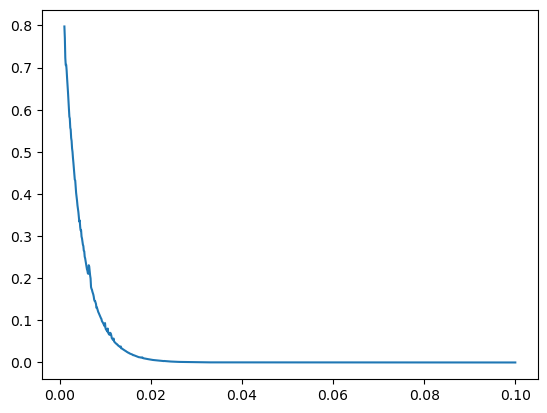

In [516]:
plt.plot(tseries,np.exp(-delphi))

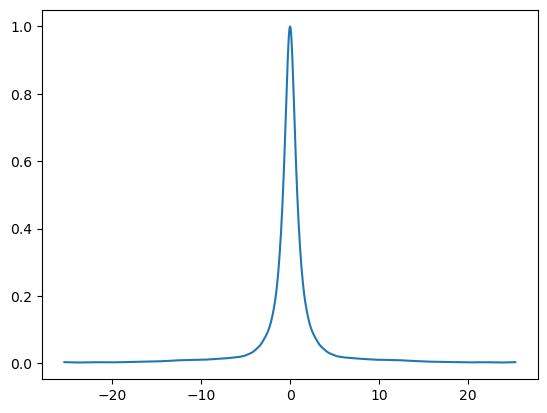

In [517]:
# Create an example array
signal = np.exp(-4*(delphi))

# Compute the discrete Fourier transform (DFT)
fourier_transform = np.fft.fft(signal)
sp = np.abs(np.fft.fftshift(fourier_transform))**2
sp = sp/max(sp)

# Compute the frequencies corresponding to the DFT
frequencies = np.fft.fftfreq(len(signal), tc)
freq = np.fft.fftshift(frequencies)

plt.plot(freq, sp)

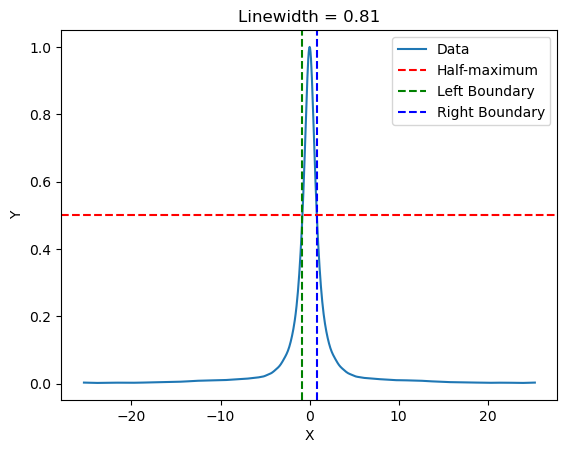

In [518]:
# Generate sample data
x = freq
y = sp  # Gaussian-like peak centered at x=5

# Find the maximum value and its index
max_value = np.max(sp)
min_value = np.min(sp)
max_index = np.argmax(y)

# Calculate half-maximum value
half_max_value = (max_value-min_value) / 2 + min_value

# Find the data points nearest to half-maximum on both sides of the peak
left_idx = np.argmin(np.abs(y[:max_index] - half_max_value))
right_idx = np.argmin(np.abs(y[max_index:] - half_max_value)) + max_index

# Calculate FWHM
fwhm = x[right_idx] - x[left_idx]

# Plot the data and highlight the FWHM region
plt.plot(x, y, label='Data')
plt.axhline(half_max_value, color='red', linestyle='--', label='Half-maximum')
plt.axvline(x[left_idx], color='green', linestyle='--', label='Left Boundary')
plt.axvline(x[right_idx], color='blue', linestyle='--', label='Right Boundary')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Linewidth = {fwhm/2:.2f}')
plt.show()


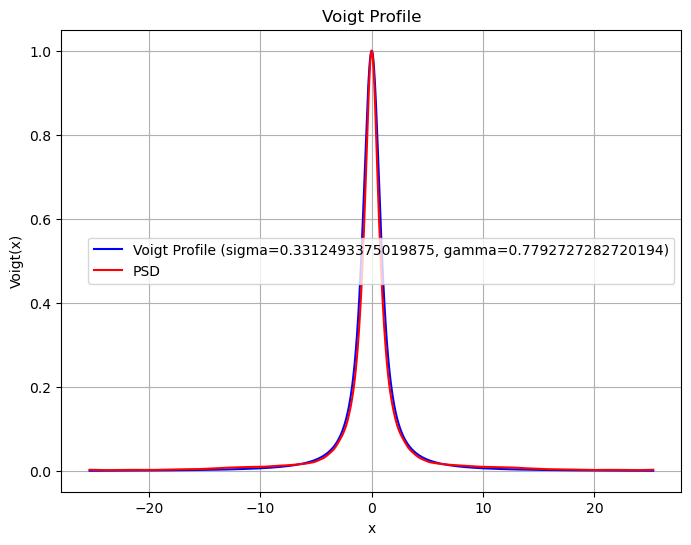

In [537]:
# Define the Voigt function
def voigt(x, sigma, gamma):
    z = (x + 1j * gamma) / (sigma * np.sqrt(2))
    return np.real(wofz(z)).astype(float) / (sigma * np.sqrt(2 * np.pi))

# Generate x-values
x = freq

# Set the parameters for the Voigt profile
sigma = si / (16*np.sqrt(3.56))   # Gaussian standard deviation
gamma = (4*np.pi**2)*tc   # Lorentzian HWHM (half-width at half-maximum)

# Calculate the Voigt profile
y = voigt(x, sigma, gamma)
y = y/max(y)

# Plot the Voigt profile
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=f'Voigt Profile (sigma={sigma}, gamma={gamma})', color='blue')
plt.plot(freq, sp, label=f'PSD', color='Red')
plt.xlabel('x')
plt.ylabel('Voigt(x)')
plt.title('Voigt Profile')
plt.grid(True)
plt.legend()
plt.show()
